# TP2: Optimización

Para este trabajo se busca la implementación de una SVM (Support Vector Machine). Dado que las SVM
son un ejemplo de clasificadores que responden a la solución de un problema de optimización convexo, el
objetivo es que el alumno pueda internalizarse con conceptos de optimización a partir de un ejemplo práctico
y de interés.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

1. Escribir una función que calcule el gradiente para la función de costo J(w, b) dada por (1).

In [3]:
def cost_function(w, x, y, C, b):      
  return 0.5 * np.linalg.norm(w) ** 2 + C * max(0, 1 - y * (w.T.dot(x) + b))

In [4]:
from collections import defaultdict
class Variable:
  def __init__(self, value, local_gradients=()):
    self.value = value
    self.local_gradients = local_gradients

  def __add__(self, other):
    "crea una variable que resulta de sumar dos variables."
    return add(self,other)
  
  def __subtract__(self, other):
    return subtract(self, other)
  
  def __mult_by_constant(self,const):
    return mult_by_constant(self, const)
  
  def __square__(self):
    "crea una variable que reulta de elevar al cuadrado otra variable"
    return square(self)
  
  def __add__(self, other):
    "crea una variable que resulta de sumar dos variables."
    return add(self, other)

# Defino las funciones que necesito para armar la funcion de Rosenbrock
def square(a):
  "crea una variable que reulta de elevar al cuadrado otra variable"
  value = np.power(a.value, 2)
  local_gradients = (
      (a, 2*a.value),) # the local derivative with respect to a is 2a.value
  return Variable(value, local_gradients)

def add(a, b):
  "crea una variable que resulta de sumar dos variables."
  value = a.value + b.value    
  local_gradients = (
    (a, 1),  # the local derivative with respect to a is 1
    (b, 1)   # the local derivative with respect to b is 1
  ) 
  return Variable(value, local_gradients)

def subtract(a, b):
  value = a.value - b.value    
  local_gradients = (
    (a, 1),  # the local derivative with respect to a is 1
    (b, -1)   # the local derivative with respect to b is 1
  ) 
  return Variable(value, local_gradients)

def mult_by_constant(a, constant):
  "crea una variable que resulta de multiplicar dos variables."
  value = constant * a.value    
  local_gradients = (
    (a, constant),
  ) 
  return Variable(value, local_gradients)

def mult_by_vector_post(a, const):
  "crea una variable que resulta de multiplicar dos variables."
  value = a.value.dot(const)    
  local_gradients = (
    (a, const),
  ) 
  return Variable(value, local_gradients)

def mult_by_vector_pre(const, a):
  "crea una variable que resulta de multiplicar dos variables."
  value = const.value.dot(a.value)    
  local_gradients = (
    (a, const.value),
  ) 
  return Variable(value, local_gradients)

def norm_func(a):
    value = np.linalg.norm(a.value)
    local_gradients = ((a, a.value / np.linalg.norm(a.value)),)
    return Variable(value, local_gradients)

def max_func(a, b):
    value = np.max(np.array([a, b.value[0]]))
    if a > 1:
        local_gradients = ((b, -1),)
    else:
        local_gradients = ((b, 0),)
    return Variable(value, local_gradients)

def transpose_func(a):
    value = a.value.T
    local_gradients = ((a, a.value),)
    return Variable(value, local_gradients)


2. Usar la función del item anterior para implementar el algoritmo de gradiente descendiente estocástico
(SGD). Usar como criterio de corte la variación en la función de pérdida entre un paso y el siguiente
(cortar si $ \Delta J< \epsilon$ ).

In [12]:
w = Variable(np.array([1, 1]))
b = Variable(np.array([1]))

def optimize_function(update_func, params, hyper_params, epochs, states=(), add_gradient_noise=False):
    w = Variable(params[0])
    b = Variable(params[1])
    x = params[2]
    y = params[3]
    C = 0.01
    for epoch in range(epochs):
        for i in range(len(x)):
            v1 = norm_func(w)
            v2 = square(v1)
            v3 = mult_by_constant(v2, 0.5)
            v4 = transpose_func(w)
            v5 = mult_by_vector_post(v4, x[i])
            v6 = add(v5, b)
            v7 = mult_by_constant(v6, y[i])
            v8 = subtract(Variable(1), v7)
            v9 = max_func(0, v8)
            v10 = mult_by_constant(v9, C)
            loss = add(v3, v10)
            print(loss.value)
            if loss.value < 0.001:
                break
            grads = get_gradients(loss)

            w, b, states = update_func(w, b, grads=grads, states=states, hyper_params=hyper_params)
            print(w.value, b.value)
    
    return w, b


In [6]:
def get_gradients(variable):
  """ Compute the first derivatives of `variable` 
  with respect to child variables.
  """
  gradients = defaultdict(lambda: 0)
  
  def compute_gradients(variable, path_value):
      for child_variable, local_gradient in variable.local_gradients:
          # "Multiply the edges of a path":
          value_of_path_to_child = path_value * local_gradient
          # "Add together the different paths":
          gradients[child_variable] += value_of_path_to_child
          # recurse through graph:
          compute_gradients(child_variable, value_of_path_to_child)
  
  compute_gradients(variable, path_value=1)
  # (path_value=1 is from `variable` differentiated w.r.t. itself)
  return gradients

In [7]:
def SGD_update(x, y, grads, states, hyper_params):
    x.value = x.value - hyper_params['lr'] * grads[x]
    y.value = y.value - hyper_params['lr'] * grads[y] 
    return x, y, []

In [9]:
def SGD_update(w, b, grads, hyper_params):
    w = w - hyper_params['lr'] * grads["w"]
    b = b - hyper_params['lr'] * grads["b"] 
    return w, b

In [231]:
def optimize_function(update_func, params, hyper_params, epochs, states=(), add_gradient_noise=False):
    w = params[0]
    b = params[1]
    x = params[2]
    y = params[3]
    C = 0.1
    epsilon = 0.001
    J_list = [100]
    for epoch in range(epochs):

        if epoch % 5 == 0:
            print("Epoch {epoch}: loss = {J}".format(epoch=epoch, J=J_list[-1]))
            print("w = {w}, b = {b}".format(w=w, b=b))
            x_lin = np.linspace(-4, 4, 100)
            y_lin = -w[0] / w[1] * x_lin - b 
            # Graficar valores de entrnamiento y el hiperplano
            plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
            plt.plot(x_lin, y_lin, 'k-')
            plt.xlabel("V1")
            plt.ylabel("V2")
            plt.show()

        for i in range(len(x)):
            #i = np.random.randint(len(x))
            grads = {}
            t = 1 - y[i] * (w.T.dot(x[i]) + b)
            dl = -1 if t < 1 else 0
            grads = {}
            grads["w"] = w + C * dl * (-y[i] * x[i].T)
            grads["b"] = C * dl * (-y[i])
            w, b = update_func(w, b, grads=grads, hyper_params=hyper_params)
            #J = cost_function(w, x[i], y[i], C, b)

        J_sum = sum([max(0, 1 - y[i] * w.T.dot(x[i]) + b) for i in range(len(x))])
        J = 0.5 * np.linalg.norm(w) ** 2 + C * J_sum
        J_list.append(J)    
        """ if J_list[-2] - J_list[-1] < epsilon:
            print("Breaking epoch {epoch}".format(epoch=epoch))
            print("loss = {loss}".format(loss=J_list[-1]))
            break """
         
                
    return w, b

In [ ]:
#J_sum = sum([max(0, 1 - y[i] * w.T.dot(x[i]) + b) for i in range(len(x))])
#J = 0.5 * np.linalg.norm(w) ** 2 + C * J_sum

3. Cargar los datos que se encuentran en el archivo train.csv, y usarlos para entrenar una SVM basándose
en el SGD implementado.

In [6]:
import pandas as pd

In [7]:
# Cargar datos para el entrenamiento
train_df = pd.read_csv('train.csv')
x_1_train = train_df["V1"].to_numpy()
x_2_train = train_df["V2"].to_numpy() 
x_train = np.array([x_1_train, x_2_train]).T
y_train = train_df["label"].to_numpy()

Epoch 0: loss = 100
w = [ 1 -1], b = [-1]


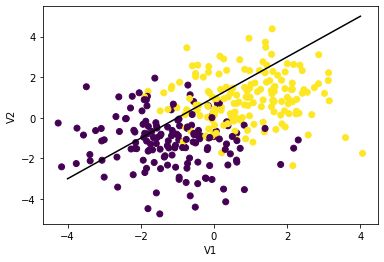

Epoch 5: loss = [7.81661756]
w = [-0.01315222 -0.09155047], b = [-0.8648]


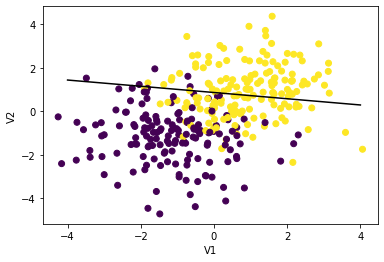

Epoch 10: loss = [12.86496939]
w = [-0.05319324 -0.05741474], b = [-0.7118]


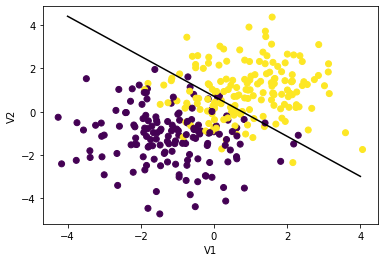

Epoch 15: loss = [17.76761363]
w = [-0.05482018 -0.05602774], b = [-0.5588]


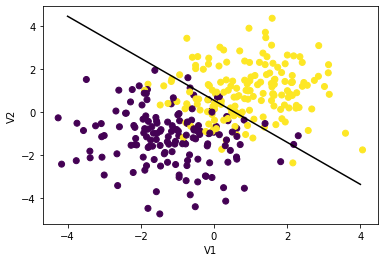

Epoch 20: loss = [22.6638837]
w = [-0.05488629 -0.05597138], b = [-0.4058]


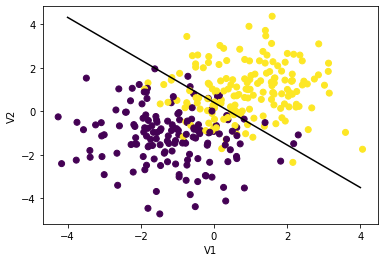

Epoch 25: loss = [27.09837341]
w = [-0.05025473 -0.05010567], b = [-0.2564]


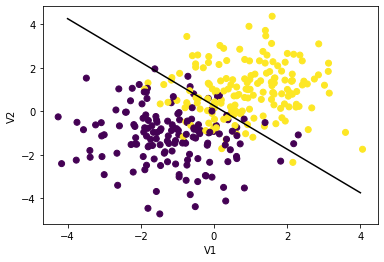

########################################
Los valores obtenidos luego del entrenamiento son
w = [-0.03686227 -0.0365735 ], b = [-0.1234]


In [307]:
start_w = np.array([1, -1])
start_b = np.array([-1])

learning_rate = 0.002
epochs = 30

w, b = optimize_function(SGD_update, params=[start_w, start_b, x_train, y_train], hyper_params={'lr': learning_rate}, epochs=epochs, add_gradient_noise=False)
#w = w / np.linalg.norm(w)
print("#"*40)
print("Los valores obtenidos luego del entrenamiento son")
print("w = {w}, b = {b}".format(w=w, b=b))
w_g = w 
b_g = w[0]


Text(0, 0.5, 'V2')

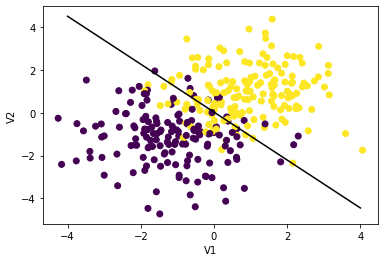

In [244]:
import matplotlib.pyplot as plt

x_lin = np.linspace(-4, 4, 100)
y_lin = -w[0] / w[1] * x_lin - b

# Graficar valores de entrnamiento y el hiperplano
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.plot(x_lin, y_lin, 'k-')
plt.xlabel("V1")
plt.ylabel("V2")

4. Importar la función SVC del paquete svm de la librería Scikit-Learn (from sklearn.svm import SVC).
Usarlo para entrenar una SVM. Comparar los valores de w y b obtenidos con esta librería contra los
hallados por gradiente descendiente. Analizar los vectores soporte hallados.

In [248]:
from sklearn.svm import SVC
C = 1
# Se crea el objeto SVC
svm = SVC(C=C, kernel="linear")
# Se entrena con los valores de entrenamiento
svm.fit(x_train, y_train)
# Se obtienen los vectores soporte
svm.support_vectors_
# Obtienen los coeficientes w
w = svm.coef_[0] / np.linalg.norm(svm.coef_[0])
b = svm.intercept_[0]
print("El vector w normal al hiperplano es:\nw = {w}".format(w=w))
print("El valor b de offset :\nb = {b}".format(b=b))
w_s = w
b_s = b

El vector w normal al hiperplano es:
w = [0.69278106 0.72114798]
El valor b de offset :
b = 0.48684297616563965


Text(0, 0.5, 'V2')

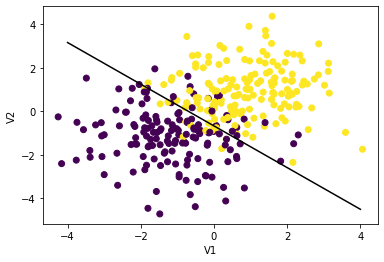

In [247]:
import matplotlib.pyplot as plt

x_lin = np.linspace(-4, 4, 100)
y_lin = -w[0] / w[1] * x_lin - b / w[1]

# Graficar valores de entrnamiento y el hiperplano
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.plot(x_lin, y_lin, 'k-')
plt.xlabel("V1")
plt.ylabel("V2")


Existen 89 vectores soporte
Se grafican los vectores soporte:


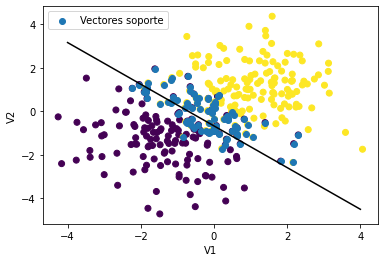

In [330]:
# Se obtienen los vectores soportes
support_vectors = svm.support_vectors_
support_index = svm.support_

print("Existen {} vectores soporte".format(len(support_index)))
print("Se grafican los vectores soporte:")

# Graficar valores de entrnamiento y el hiperplano
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], label="Vectores soporte")
plt.plot(x_lin, y_lin, 'k-')
plt.xlabel("V1")
plt.ylabel("V2")
plt.legend()


5. Cargar los datos que se encuentran en el archivo test.csv y analizar la performance de la SVM
entrenada por ambos métodos. Usar como métrica de error la proporción de etiquetas predichas correctamente.
¿Coinciden las predicciones?

In [252]:
# Cargar datos para el testing 
test_df = pd.read_csv('test.csv')
x_1_test = test_df["V1"].to_numpy()
x_2_test = test_df["V2"].to_numpy() 
x_test = np.array([x_1_test, x_2_test]).T
y_test = test_df["label"].to_numpy()

In [253]:
# Obtener el error de clasificacion usando sklearn
score = svm.score(x_test, y_test)
print("La proporcion de muestras clasificadas correctamente es: {score}".format(score=score))

La proporcion de muestras clasificadas correctamente es: 0.925


In [314]:
# Obtener el error de clasificación con gradiente decendiente
w_g = w_g / np.linalg.norm(w_g)
print(w_g)
total = 0
success = 0
for i in range(len(x_test)):
    predicted = 1 if (w_g.T.dot(x_test[i]) + b_g) > 0 else -1
    real = y_test[i]
    if predicted == real:
        success += 1
    total += 1

score_g = success / total
print("La proporcion de muestras clasificadas correctamente es: {score}".format(score=score_g))


[0.70988182 0.70432081]
La proporcion de muestras clasificadas correctamente es: 0.925


6. Analizar que ocurre cuando se quita del dataset de entrenamiento un vector soporte. ¿Y si sacamos
uno que no lo era?